In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds

Завдання 1: Реалізація SVD 

In [2]:

def custom_svd(A):
    ATA = np.dot(A.T, A)
    AAT = np.dot(A, A.T)
    
    eigvals_V, V = np.linalg.eigh(ATA)
    eigvals_U, U = np.linalg.eigh(AAT)
    
    sorted_indices_V = np.argsort(eigvals_V)[::-1]
    sorted_indices_U = np.argsort(eigvals_U)[::-1]
    
    V = V[:, sorted_indices_V]
    U = U[:, sorted_indices_U]
    eigvals_V = eigvals_V[sorted_indices_V]
    
    singular_values = np.sqrt(eigvals_V)
    
    Σ = np.zeros_like(A, dtype=float)
    np.fill_diagonal(Σ, singular_values)
    
    for i in range(min(A.shape)):
        if np.dot(A @ V[:, i], U[:, i]) < 0:
            U[:, i] = -U[:, i]
    
    return U, Σ, V.T


In [3]:
A = np.array([[1, 2], [3, 4], [5, 6]])
U, Σ, V_T = custom_svd(A)
U, Σ, V_T

(array([[ 0.2298477 ,  0.88346102,  0.40824829],
        [ 0.52474482,  0.24078249, -0.81649658],
        [ 0.81964194, -0.40189603,  0.40824829]]),
 array([[9.52551809, 0.        ],
        [0.        , 0.51430058],
        [0.        , 0.        ]]),
 array([[ 0.61962948,  0.78489445],
        [-0.78489445,  0.61962948]]))

In [4]:
A_reconstructed = U @ Σ @ V_T
print("A_reconstructed:", A_reconstructed)

A_reconstructed: [[1. 2.]
 [3. 4.]
 [5. 6.]]


Завдання 2 Частина 1: Алгоритм рекомендацій, Візуалізація даних 

In [5]:
file_path = 'ratings.csv'
df = pd.read_csv(file_path)

ratings_matrix = df.pivot(index='userId', columns='movieId', values='rating')

In [6]:
ratings_matrix = ratings_matrix.dropna(thresh=200, axis=0)
ratings_matrix = ratings_matrix.dropna(thresh=100, axis=1)  

In [7]:
ratings_matrix_filled = ratings_matrix.fillna(2.5)
R = ratings_matrix_filled.values
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [8]:
U, sigma, Vt = svds(R_demeaned, k=3)
U

array([[-0.11701519,  0.0486775 , -0.10423191],
       [ 0.11847179,  0.08575014, -0.25393107],
       [ 0.04659884,  0.2114704 ,  0.06167357],
       [-0.03369839,  0.03431137,  0.01493453],
       [-0.11315672, -0.06023676, -0.09295234],
       [ 0.        ,  0.        ,  0.        ],
       [-0.00176799,  0.06557723, -0.04769789],
       [ 0.0223581 , -0.03028765,  0.01808238],
       [ 0.14094734, -0.18267287,  0.0629276 ],
       [-0.02632272,  0.00939526,  0.06325497],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.0808657 , -0.0546264 ,  0.07019834],
       [ 0.05670146, -0.0201186 , -0.16508456],
       [-0.12109341,  0.04722163, -0.04750486],
       [-0.02915682,  0.03123462,  0.02748431],
       [ 0.09201204, -0.09678061, -0.06990315],
       [ 0.01555938, -0.02934068,  0.06364908],
       [-0.01879314,  0.00076514,  0.16784247],
       [-0.13257457,  0.07801818, -0.16788099],
       [-0.00475961,  0.0016749 ,  0.01720317],
       [-0.05804253,  0.12877441, -0.021

In [9]:
Vt

array([[ 0.09296504,  0.43669991,  0.2693743 ,  0.12853428, -0.08870624,
        -0.83886728],
       [-0.03512916, -0.63524784,  0.76001901, -0.04926365,  0.06453129,
        -0.10490964],
       [-0.45685515,  0.48020396,  0.42360706, -0.41995691, -0.33327777,
         0.30627881]])

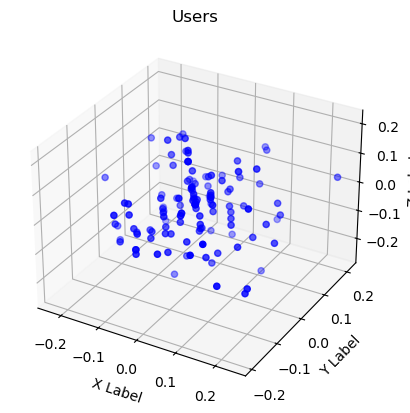

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(U[:, 0], U[:, 1], U[:, 2], c='b', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('Users')

plt.show()

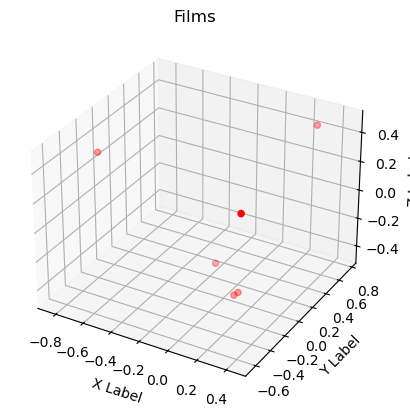

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Vt[0, :], Vt[1, :], Vt[2, :], c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('Films')

plt.show()

Завдання 2 Частина 2: Алгоритм рекомендацій, створення підбірки рекомендованих фільмів для користувачів 

In [12]:
movies_df = pd.read_csv('movies.csv')
num_users, num_items = R_demeaned.shape
print(f"Number of users: {num_users}, Number of items: {num_items}")

if min(num_users, num_items) <= 1:
    raise ValueError("Матриця має занадто малі розміри для SVD.")

k = min(50, num_users - 1, num_items - 1)
print(f"Selected k: {k}")

U, sigma, Vt = svds(R_demeaned, k=k)
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=ratings_matrix.columns, index=ratings_matrix.index)


Number of users: 134, Number of items: 6
Selected k: 5


In [13]:
def recommend_movies(predictions_df, user_id, movies_df, original_ratings_df, num_recommendations=10):
    user_row_number = user_id - 1
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    user_data = original_ratings_df[original_ratings_df.userId == (user_id)]
    user_full = (user_data.merge(movies_df, how='left', left_on='movieId', right_on='movieId').
                 sort_values(['rating'], ascending=False))
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how='left',
               left_on='movieId',
               right_on='movieId').
         rename(columns={sorted_user_predictions.name: 'Predictions'}).  
         sort_values('Predictions', ascending=False).
         iloc[:num_recommendations, :-1])
    return user_full, recommendations


In [14]:
user_full, recommendations = recommend_movies(preds_df, 1, movies_df, df, 10)

recommendations


,movieId,title,genres
0,2,Jumanji (1995),Adventure|Children|Fantasy
1,4,Waiting to Exhale (1995),Comedy|Drama|Romance
2,5,Father of the Bride Part II (1995),Comedy
3,7,Sabrina (1995),Comedy|Romance
4,8,Tom and Huck (1995),Adventure|Children
5,9,Sudden Death (1995),Action
6,10,GoldenEye (1995),Action|Adventure|Thriller
7,11,"American President, The (1995)",Comedy|Drama|Romance
8,12,Dracula: Dead and Loving It (1995),Comedy|Horror
9,13,Balto (1995),Adventure|Animation|Children
